In [1]:
# Install PyTorch (if not already installed)
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

# Install other required packages
!pip install opencv-python matplotlib

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113


In [2]:
# Clone the repository
!git clone https://github.com/facebookresearch/detectron2.git
%cd detectron2

# Install Detectron2
!pip install -e .

Cloning into 'detectron2'...
remote: Enumerating objects: 15777, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 15777 (delta 7), reused 21 (delta 4), pack-reused 15743 (from 1)
Receiving objects: 100% (15777/15777), 6.35 MiB | 19.35 MiB/s, done.
Resolving deltas: 100% (11501/11501), done.
/kaggle/working/detectron2
Obtaining file:///kaggle/working/detectron2
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.

In [3]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog

In [4]:
from detectron2.data.datasets import register_coco_instances
# Register the datasets
register_coco_instances("my_dataset_train", {}, "/kaggle/input/traffic-object-recognition/train/_annotations.coco.json", "/kaggle/input/traffic-object-recognition/train")
register_coco_instances("my_dataset_val", {}, "/kaggle/input/traffic-object-recognition/valid/_annotations.coco.json", "/kaggle/input/traffic-object-recognition/valid")
register_coco_instances("my_dataset_test", {}, "/kaggle/input/traffic-object-recognition/test/_annotations.coco.json", "/kaggle/input/traffic-object-recognition/test")

WARNING [09/28 16:16:29 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[09/28 16:16:29 d2.data.datasets.coco]: Loaded 494 images in COCO format from /kaggle/input/traffic-object-recognition/train/_annotations.coco.json


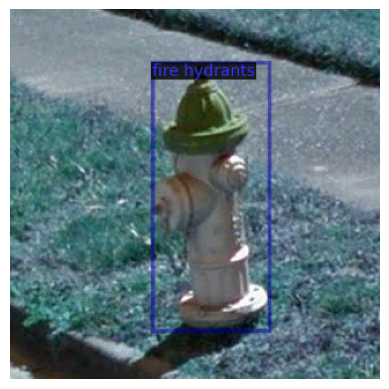

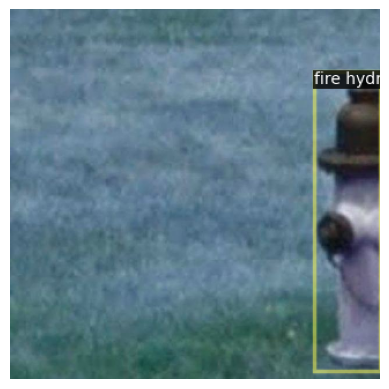

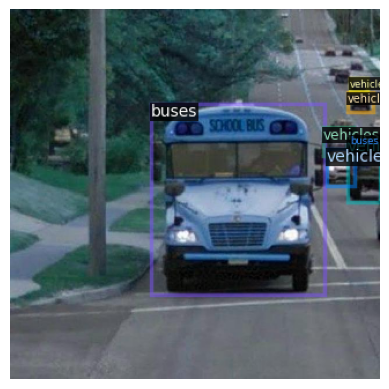

In [5]:
import cv2
import random
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer

#visualize training data
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    
    # Your existing visualization code
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)

    # Display using matplotlib
    plt.imshow(vis.get_image()[:, :, ::-1])  # Convert BGR to RGB
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()    

In [6]:
cfg = get_cfg()
# load a configuration file with ResNet-based architecture, specifically ResNeXt-101 32x8d (denoted by the "faster_rcnn_X_101_32x8d_FPN_3x.yaml" model)
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)

cfg.DATALOADER.NUM_WORKERS = 4
# Set the initial weights from the ResNet-101 backbone pre-trained on COCO
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001

# Set solver parameters like learning rate and max iterations
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 2000 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (1000, 1400)
cfg.SOLVER.GAMMA = 0.05


cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 12

cfg.TEST.EVAL_PERIOD = 500

In [7]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [8]:
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118


In [9]:
import torch
print("CUDA available:", torch.cuda.is_available())

CUDA available: True


In [10]:
# import os
# os.makedir(cfg.OUTPUT_DIR, exist_ok = True)
# Create a trainer instance
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)  # Load weights or start training
trainer.train()  # Start training

[09/28 16:16:45 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_68b088.pkl: 421MB [00:01, 236MB/s]                               


[09/28 16:16:47 d2.engine.train_loop]: Starting training from iteration 0


/opt/conda/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[09/28 16:17:44 d2.utils.events]:  eta: 1:32:45  iter: 19  total_loss: 3.616  loss_cls: 2.496  loss_box_reg: 0.9721  loss_rpn_cls: 0.1792  loss_rpn_loc: 0.04556    time: 2.6977  last_time: 2.8346  data_time: 0.0199  last_data_time: 0.0102   lr: 1.931e-06  max_mem: 6902M
[09/28 16:18:53 d2.utils.events]:  eta: 1:26:31  iter: 39  total_loss: 3.509  loss_cls: 2.465  loss_box_reg: 0.9112  loss_rpn_cls: 0.1323  loss_rpn_loc: 0.0385    time: 2.6686  last_time: 1.8260  data_time: 0.0106  last_data_time: 0.0106   lr: 2.911e-06  max_mem: 6902M
[09/28 16:19:48 d2.utils.events]:  eta: 1:28:44  iter: 59  total_loss: 3.49  loss_cls: 2.401  loss_box_reg: 0.9788  loss_rpn_cls: 0.0362  loss_rpn_loc: 0.02472    time: 2.7004  last_time: 2.9596  data_time: 0.0102  last_data_time: 0.0095   lr: 3.891e-06  max_mem: 6902M
[09/28 16:20:42 d2.utils.events]:  eta: 1:26:15  iter: 79  total_loss: 3.323  loss_cls: 2.315  loss_box_reg: 0.9436  loss_rpn_cls: 0.03411  loss_rpn_loc: 0.01645    time: 2.7057  last_time:

In [11]:
import os
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("my_dataset_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_test")
inference_on_dataset(trainer.model, val_loader, evaluator)

[09/28 17:49:30 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


/opt/conda/lib/python3.10/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

WARNING [09/28 17:49:31 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [09/28 17:49:31 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[09/28 17:49:31 d2.data.datasets.coco]: Loaded 133 images in COCO format from /kaggle/input/traffic-object-recognition/test/_annotations.coco.json
[09/28 17:49:31 d2.data.build]: Distribution of instances among all 8 categories:
|   category    | #instances   |   category    | #instances   |  category   | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:-----------:|:-------------|
| road-traffic  | 0            |   bicycles    | 22           |    buses    | 12           |
|  crosswalks   | 81           | fire hydrants | 23           | motorcycles | 30           |
| traffic lig.. | 129          |   vehicles    | 209          |             |              

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/28 17:49:33 d2.evaluation.evaluator]: Inference done 11/133. Dataloading: 0.0012 s/iter. Inference: 0.1791 s/iter. Eval: 0.0004 s/iter. Total: 0.1807 s/iter. ETA=0:00:22
[09/28 17:49:38 d2.evaluation.evaluator]: Inference done 39/133. Dataloading: 0.0018 s/iter. Inference: 0.1796 s/iter. Eval: 0.0004 s/iter. Total: 0.1819 s/iter. ETA=0:00:17
[09/28 17:49:43 d2.evaluation.evaluator]: Inference done 67/133. Dataloading: 0.0018 s/iter. Inference: 0.1796 s/iter. Eval: 0.0004 s/iter. Total: 0.1819 s/iter. ETA=0:00:12
[09/28 17:49:48 d2.evaluation.evaluator]: Inference done 95/133. Dataloading: 0.0018 s/iter. Inference: 0.1797 s/iter. Eval: 0.0003 s/iter. Total: 0.1819 s/iter. ETA=0:00:06
[09/28 17:49:53 d2.evaluation.evaluator]: Inference done 123/133. Dataloading: 0.0017 s/iter. Inference: 0.1798 s/iter. Eval: 0.0003 s/iter. Total: 0.1820 s/iter. ETA=0:00:01


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/28 17:49:55 d2.evaluation.evaluator]: Total inference time: 0:00:23.368178 (0.182564 s / iter per device, on 1 devices)
[09/28 17:49:55 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:23 (0.179804 s / iter per device, on 1 devices)
[09/28 17:49:55 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/28 17:49:55 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[09/28 17:49:55 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[09/28 17:49:55 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/28 17:49:55 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.08 seconds.
[09/28 17:49:55 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[09/28 17:49:55 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.03 seconds.
 Average Precision  (AP)

OrderedDict([('bbox',
              {'AP': 43.03424889152313,
               'AP50': 76.13877971566446,
               'AP75': 42.708421119407994,
               'APs': 15.572209674882803,
               'APm': 35.350641432152315,
               'APl': 51.519123819372446,
               'AP-road-traffic': nan,
               'AP-bicycles': 40.07023532902722,
               'AP-buses': 50.99186477713705,
               'AP-crosswalks': 10.028622325065944,
               'AP-fire hydrants': 56.959619717627874,
               'AP-motorcycles': 51.06187839468357,
               'AP-traffic lights': 43.01707542555355,
               'AP-vehicles': 49.11044627156672})])

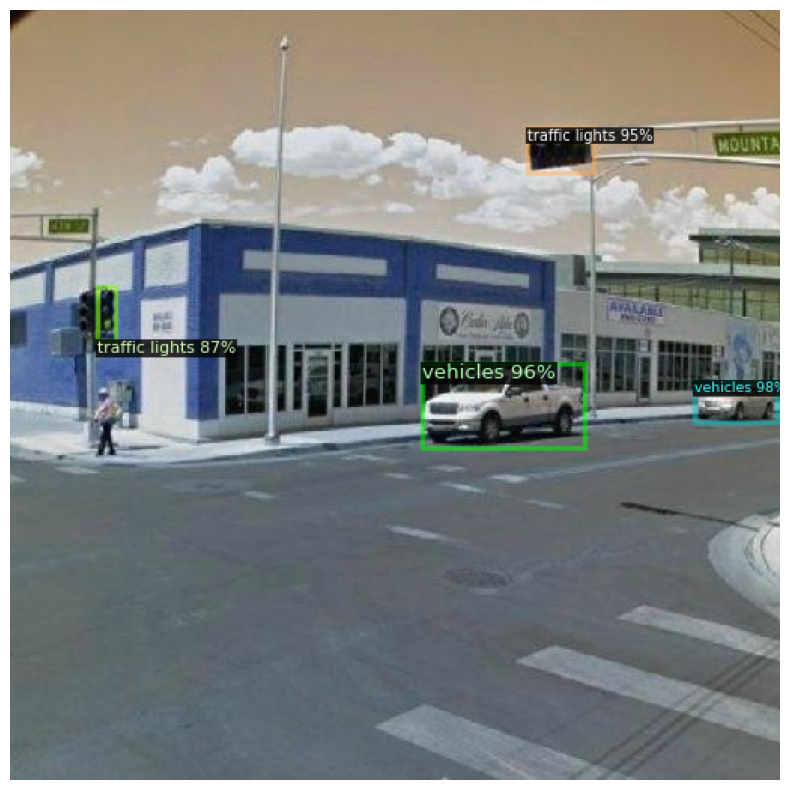

In [28]:
from detectron2.utils.visualizer import Visualizer
import matplotlib.pyplot as plt
import cv2
import glob

# Define or access the test metadata
test_metadata = MetadataCatalog.get("my_dataset_test")

# Loop through test images
for imageName in glob.glob('/kaggle/input/traffic-object-recognition/test/1653385923735_jpg.rf.caad53fe93179609c068a7adf45b3b0c.jpg'):
    im = cv2.imread(imageName)  # Read the image
    outputs = predictor(im)  # Get predictions
    
    # Visualize the output
    v = Visualizer(im[:, :, ::-1],  # Convert BGR to RGB for visualization
                   metadata=test_metadata, 
                   scale=0.8)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    # Prepare the image for display with matplotlib
    output_image = out.get_image()[:, :, ::-1]  # Convert back to RGB for matplotlib

    # Display the image using matplotlib
    plt.figure(figsize=(10, 10))  # Set figure size
    plt.imshow(output_image)  # Display the image
    plt.axis('off')  # Turn off axis labels
    plt.show()  # Render the image
